# CMR API Demo: Linear and Non-Linear IV

This notebook demonstrates the new API for the Conditional Moment Restrictions library.
We will solve two problems:
1. **Linear IV**: Structural function $f(x) = 2x$
2. **Non-parametric IV**: Structural function $f(x) = \log(|2x| + 1)$


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from cmr.factory import create_estimator
from cmr.config import OptimizationConfig, KMMConfig

# Set seed
np.random.seed(42)
torch.manual_seed(42)


## 1. Linear IV

Data generation:

- $Z \sim U[-3, 3]$
- $U \sim N(0, 1)$
- $X = Z + 0.5 U + N(0, 0.1)$
- $Y = 2X + U + N(0, 0.1)$


In [2]:
def generate_linear_iv(n=1000):
    U = np.random.normal(0, 1, (n, 1))
    Z = np.random.uniform(-3, 3, (n, 1))
    X = Z + 0.5 * U + np.random.normal(0, 0.1, (n, 1))
    Y = 2 * X + U + np.random.normal(0, 0.1, (n, 1))
    return {"t": X, "y": Y, "z": Z}


data_lin = generate_linear_iv(1000)
test_lin = generate_linear_iv(1000)


### Method 1: MMR (Direct Estimation via Factory)

We use a simple linear model.

In [3]:
model_lin = torch.nn.Linear(1, 1)


def moment_fn(pred, y):
    return pred - y


# Use factory
est_lin = create_estimator(
    method="MMR",
    model=model_lin,
    moment_function=moment_fn,
    train_data_size=1000,
    verbose=True,
)

print("Training Linear IV with MMR...")
est_lin.train(data_lin)
print(f"Estimated weight: {est_lin.model.model.weight.item():.4f} (True: 2.0000)")
print(f"Estimated intercept: {est_lin.model.model.bias.item():.4f} (True: 0.0000)")


Using GPU: NVIDIA GeForce RTX 5070
Training Linear IV with MMR...
Starting training on GPU ...
MMR Loss: 0.0003166534297633916
Estimated weight: 2.0238 (True: 2.0000)
Estimated intercept: 0.0195 (True: 0.0000)


## 2. Non-parametric IV

$Y = \log(|2X| + 1) + U + \epsilon$

In [4]:
def generate_nonlinear_iv(n=1000):
    U = np.random.normal(0, 1, (n, 1))
    Z = np.random.uniform(-3, 3, (n, 1))
    X = Z + U + np.random.normal(0, 0.1, (n, 1))
    Y = np.log(np.abs(2 * X) + 1) + U + np.random.normal(0, 0.1, (n, 1))
    return {"t": X, "y": Y, "z": Z}


data_nonlin = generate_nonlinear_iv(10_000)
test_nonlin = generate_nonlinear_iv(10_000)
x_plot = np.linspace(-4, 4, 100).reshape(-1, 1)
y_true = np.log(np.abs(2 * x_plot) + 1)


### Method 2: KMM-neural (Config Object)

We use a neural network model and configure KMM explicitly.

In [ ]:
from cmr.methods.kmm_neural import KMMNeural

model_nonlin = torch.nn.Sequential(
    torch.nn.Linear(1, 64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.Sigmoid(),
    torch.nn.Linear(32, 1),
)

config = KMMConfig(entropy_regularization=10.0, n_random_features=1000)

opt_config = OptimizationConfig(learning_rate=1e-3, max_epochs=500, batch_size=10_000)

est_kmm = KMMNeural(
    model=model_nonlin,
    moment_function=moment_fn,
    kmm_config=config,
    optimization=opt_config,
    verbose=True,
)

print("Training Non-linear IV with KMM-neural...")
est_kmm.train(data_nonlin, test_nonlin)

Using GPU: NVIDIA GeForce RTX 5070
Training Non-linear IV with KMM-neural...
Starting training on GPU ...
epoch 0, theta-obj=-9.852664, val-loss=None
epoch 100, theta-obj=-10.202824, val-loss=None
epoch 200, theta-obj=-9.948779, val-loss=None
epoch 300, theta-obj=-9.692001, val-loss=None
epoch 400, theta-obj=-9.724656, val-loss=None
time taken: 25.537562608718872
Trained for 499 epochs.


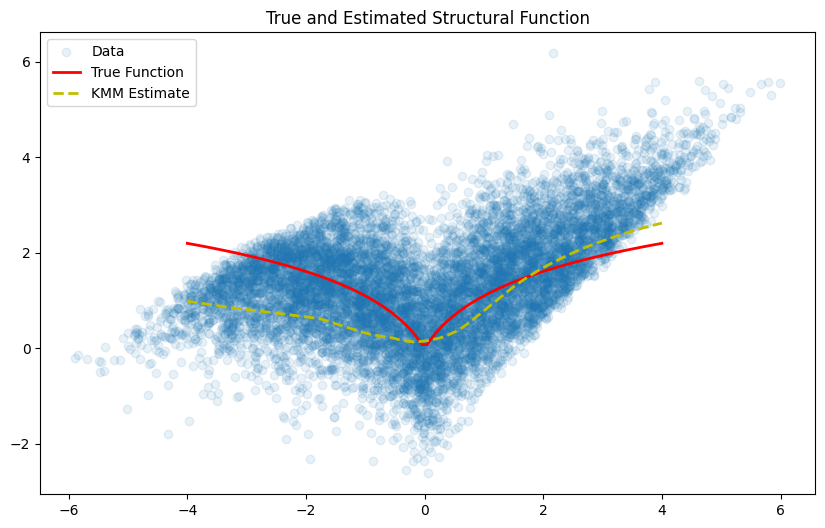

In [10]:
# Evaluate
y_pred = est_kmm.model(torch.Tensor(x_plot)).detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.scatter(data_nonlin["t"], data_nonlin["y"], alpha=0.1, label="Data")
plt.plot(x_plot, y_true, "r-", label="True Function", linewidth=2)
plt.plot(x_plot, y_pred, "y--", label="KMM Estimate", linewidth=2)
plt.legend()
plt.title("True and Estimated Structural Function")
plt.show()
